In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Pizzinelli et al. (2023) extend the AIOE framework by introducing a complementarity index that measures the extent to which AI supports rather than substitutes human labor. This index is higher for occupations where AI is more likely to enhance human abilities, taking into account both the relevance of AI applications and the broader social and technical contexts that may limit automation.

The authors construct the complementarity index using 11 of the 57 O*NET work context variables together with job zones, grouped into six dimensions. For each occupation in the SOC system, the work context variables provide a score from 0 to 100, which reflects how important or frequent a given task or condition is for that job (e.g., the importance of face-to-face discussions, the frequency of decision-making, or the degree of automation). Job Zone, by contrast, is an ordinal variable ranging from 1 to 5, which indicates the preparation time required to gain the skills for an occupation. In the index, Job Zone values are rescaled by multiplying by 20, producing a 0–100 scale consistent with the other variables. The six grouped dimensions with their work contexts are:

1. *Communication* – Face-to-Face Discussions, Public Speaking

2. *Responsibility* – Responsibility for Outcomes, Responsibility for Others’ Health

3. *Physical Conditions* – Exposure to Outdoor Environments, Physical Proximity to Others

4. *Criticality* – Consequence of Errors, Freedom of Decisions, Frequency of Decisions

5. *Routine* – Degree of Automation\*, Structured vs. Unstructured Work

6. *Skills* – proxied by Job Zone 

For each dimension, an occupation’s score is calculated as the average of its component work context variables. For example, the *Communication* dimension will have its score as the average of the score from Face-to-Face Discussions and Public Speaking. Finally, the complementarity index is obtained by taking the average across the six dimensions, providing a single measure of how strongly AI complements a given occupation.

---
\*As a note, the degree of automation was inverted because it is the only work context in which higher values indicate lower complementarity with AI. To address this, we created a new variable called degree of freedom, which is derived from the degree of automation. In this formulation, higher scores correspond to greater complementarity with AI. Formally, $$\text{Degree of Freedom} = 100 - \text{Degree of Automation}$$.

# I. Data Retrieval and Computation of Complementarity

In [95]:
# Let's get the categories first
CATEGORY_MAP = {
    "data/Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx": "Communication",
    "data/Public_Speaking.xlsx": "Communication",
    "data/Work_Outcomes_and_Results_of_Other_Workers.xlsx": "Responsibility",
    "data/Health_and_Safety_of_Other_Workers.xlsx": "Responsibility",
    "data/Determine_Tasks_Priorities_and_Goals.xlsx": "Routine",
    "data/Outdoors_Exposed_to_All_Weather_Conditions.xlsx": "Physical",
    "data/Physical_Proximity.xlsx": "Physical",
    "data/Consequence_of_Error.xlsx": "Criticality",
    "data/Frequency_of_Decision_Making.xlsx": "Criticality",
    "data/Degree_of_Automation.xlsx": "Routine",
    "data/Freedom_to_Make_Decisions.xlsx": "Criticality",
}

# Load your original files
all_dfs = []

# For each file, let's add it to all_dfs
for file_name, category_name in CATEGORY_MAP.items():
    df = pd.read_excel(file_name, skiprows=3)
    df.columns = [category_name, "Context", "SOC_Code", "Occupation"]
    
    # make score numeric and if a string, just make the score nan
    df[category_name] = pd.to_numeric(df[category_name], errors='coerce')
    if df.isnull().sum().sum():
        print(f"There's missing data in {file_name[5:]}")    
    
    all_dfs.append(df)

# Adjust Degree_of_Automation so that as it increases, complementarity increase
all_dfs[9]['Routine'] = all_dfs[9]['Routine'].apply(lambda x : 100 - x)

There's missing data in Face-to-Face_Discussions_with_Individuals_and_Within_Teams.xlsx
There's missing data in Outdoors_Exposed_to_All_Weather_Conditions.xlsx


In [96]:
# Create a dataframe that has in the SOC code 
# and the corresponding dimension score (not yet averaged tho)
# {SOC Code: {dimension: score}}
soc_dict = {}

for df in all_dfs:
    # gets the dimension
    work_context = df.columns[0]

    for _, row in df.iterrows():
        soc = row['SOC_Code']
        work_context_score = row.iloc[0]

        # O*NET already give the job zone too
        zone = row['Context']

        # Make sure the structure exists
        if soc not in soc_dict:
            soc_dict[soc] = {}
        
        # assign score for the work_context
        soc_dict[soc][work_context] = soc_dict[soc].get(work_context, 0) + work_context_score

        # assign score for the job zone
        soc_dict[soc]['Skills'] = zone

dimensions = [
    "Communication",
    "Responsibility",
    "Physical",
    "Criticality",
    "Routine",
    "Skills",
]

# get a dataframe
contexts_df = pd.DataFrame.from_dict(soc_dict, orient='index')[dimensions]

# If there is a missing score, just impute with the median
contexts_df.fillna(contexts_df.median(), inplace=True)

# Adjust the scores each dimension
coeffs = [1/2, 1/2, 1/2, 1/3, 1/2, 20]

for context, coeff in zip(contexts_df.columns, coeffs):
    contexts_df[context] = contexts_df[context].apply(lambda x : x * coeff)

contexts_df['Job'] = contexts_df.index.str[:7]
contexts_grouped_df = contexts_df.groupby('Job')[dimensions].mean()
contexts_grouped_df['Complementarity'] = contexts_grouped_df.mean(axis=1)

# Create a mapping from the SOC code to each dimension

soc_dicts = {dim: dict(zip(contexts_grouped_df.index, contexts_grouped_df[dim] / 100))
             for dim in dimensions}

# II. Sanity Check to See if Methodology was Properly Followed

To visually assess the consistency of our methodology, we compared the correlation matrix of the six dimensions we computed with the correlation matrix reported in the study. Given that the pairwise correlations in our computed matrix closely mirror those reported by Pizzinelli et al. as shown below, we can be confident that our methodology was implemented correctly.

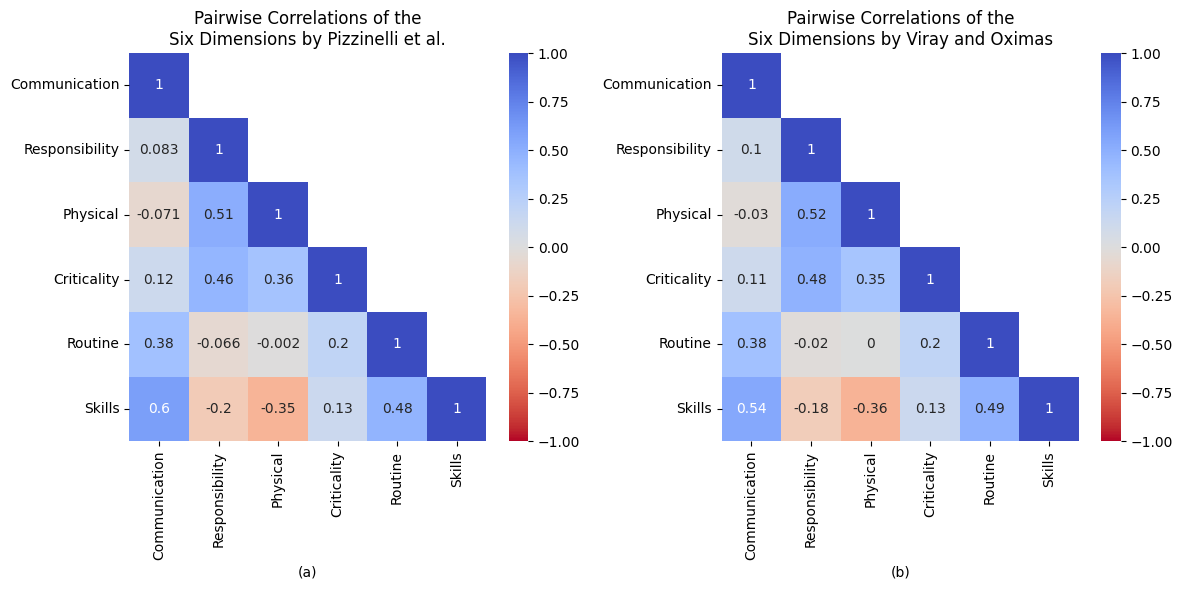

In [103]:
pizzinelli_data = np.array([
    [1,       0.083,  -0.071,  0.121,  0.379,  0.598],
    [0.083,   1,       0.510,  0.455, -0.066, -0.200],
    [-0.071,  0.510,   1,      0.363, -0.002, -0.352],
    [0.121,   0.455,   0.363,  1,      0.203,  0.127],
    [0.379,  -0.066,  -0.002,  0.203,  1,      0.476],
    [0.598,  -0.200,  -0.352,  0.127,  0.476,  1]
])

pizzinelli_df = pd.DataFrame(pizzinelli_data,
                             index=dimensions,
                             columns=dimensions)

# Mask for upper triangle
mask = np.triu(np.ones_like(pizzinelli_df, dtype=bool), k=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pizzinelli heatmap (lower triangle only)
sns.heatmap(data=pizzinelli_df,
            mask=mask,
            vmax=1,
            vmin=-1,
            cmap='coolwarm_r',
            annot=True,
            ax=ax[0])
ax[0].set_title('Pairwise Correlations of the\nSix Dimensions by Pizzinelli et al.')
ax[0].set_xlabel('(a)')

# Contexts heatmap (lower triangle only)
sns.heatmap(data=contexts_grouped_df[dimensions].corr().round(2),
            mask=mask,
            vmax=1,
            vmin=-1,
            cmap='coolwarm_r',
            annot=True,
            cbar=True,
            ax=ax[1])
ax[1].set_title('Pairwise Correlations of the\nSix Dimensions by Viray and Oximas')
ax[1].set_xlabel('(b)')

plt.tight_layout()
plt.show()

# III. Mapping Philippine Jobs to their Complementarity Scores

In [104]:
filename = '../2_soc_aioe/soc_aioe.csv'
mca_df = pd.read_csv(filename)
mca_df['Job Sector'] = mca_df['Job Sector'].apply(lambda x : x.strip())

Most jobs in the MCA list can be directly mapped to their corresponding AIOE values. However, approximately 16.92% of jobs have missing scores because ONET does not have complete work context data for these SOC codes. We impute these missing values using the mean score of their major-minor SOC group. For example, the Academic Researcher (SOC 19-1099) is assigned the mean work context score of all jobs with SOC codes starting with 19.

In [109]:
for dimension in dimensions:
    # map the soc code to the work context score
    mca_df[dimension] = mca_df['SOC'].apply(
        lambda x : soc_dicts[dimension].get(x.strip(), np.nan)
        )
    
    # if empty, impute using the mean
    mca_df[dimension] = mca_df[dimension].fillna(
    mca_df.groupby('major_minor')[dimension].transform('mean')
    )

# Get the complementarity score
mca_df['Complementarity'] = mca_df[dimensions].sum(axis=1) / 6

# Standardized scale complementarity
#mean = mca_df['Complementarity'].mean()
#std = mca_df['Complementarity'].std()
#mca_df['Complementarity'] = (mca_df['Complementarity'] - mean) / std

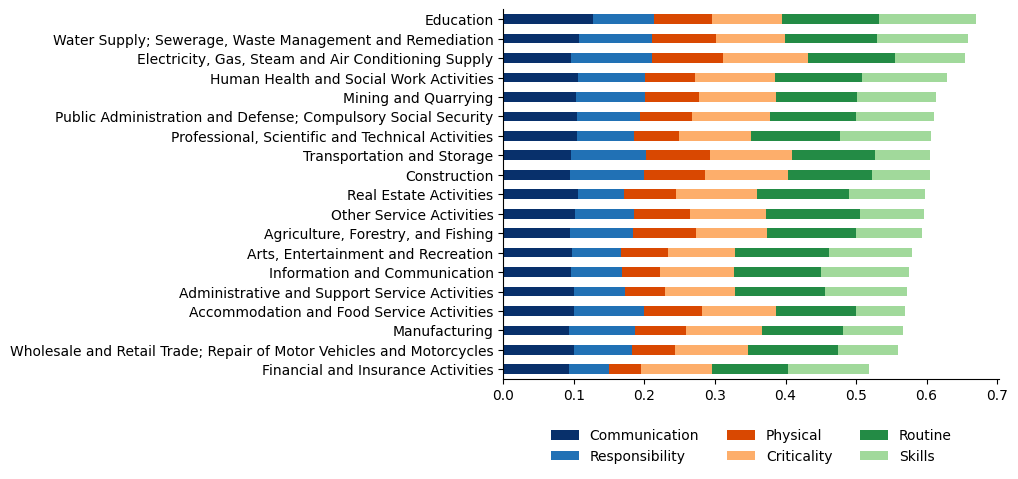

In [110]:
# Plotting time. I just want specific colors and names here
colors = {
    "Communication": "#08306b",      # dark navy blue
    "Responsibility": "#2171b5",     # medium blue
    "Physical": "#d94801", # dark orange
    "Criticality": "#fdae6b",        # light orange
    "Routine": "#238b45",            # dark green
    "Skills": "#a1d99b"              # light green
}



# Get the average contributions of each dimension to the complementarity
average_contrib = mca_df.groupby('Job Sector')[dimensions].mean() / 6

# So that once its plotted, it goes by Managers down to Skilled Agri Workers
average_contrib['total'] = average_contrib.sum(axis=1)
average_contrib.sort_values(by='total', ascending=True, inplace=True)
average_contrib.drop(columns='total', inplace=True)

# Plotting Time
average_contrib.plot(
    kind="barh",
    stacked=True,
    color=[colors[col] for col in average_contrib.columns]
)

# we want this pretty hehehehe
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('')

plt.legend(
    loc="upper center",       # place above or below plot
    bbox_to_anchor=(0.5, -0.1), # shift below the axes
    ncol=3,                   # number of columns
    frameon=False             # remove legend box outline
)

plt.show()

In [113]:
# Output the csv
relevant_cols = [
    'Job Title',
    'Job Sector',
    'Job Subsector',
    'Educational Pathway',
    'HEI with PRC (Professional Regulation Commission) Exam',
    'Some HEI',
    'AIOE',
    'Complementarity'
]

mca_df[relevant_cols].to_csv('soc_comple.csv', index=False)